# Regression - Audio

## Imports

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../')

from tcn import TCN
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from data_preparation import prepare_x_data, get_Y_labels, unscale_Y, reshape_Y, reshape_X

2022-05-28 12:11:17.487355: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Data preparation

Data preparation includes: <br>
<ul>
  <li>selecting necessary features from source files</li>
  <li>creating combined dataset for the model training</li>
  <li>reshaping data for model training.</li>

In [2]:
scaler = StandardScaler()

In [3]:
x_train = prepare_x_data('../Data/LLDs_audio_eGeMAPS/train',';', 2, scaler)

y_train = get_Y_labels('../Data/labels_metadata.csv', 60, 164, scaler)
y_train = reshape_Y(y_train,len(x_train),1,1)

In [4]:
x_test = prepare_x_data('../Data/LLDs_audio_eGeMAPS/dev',';', 2, scaler) 

y_test = get_Y_labels('../Data/labels_metadata.csv', 0, 60, scaler)
y_test = reshape_Y(y_test,len(x_test),1,1)

In [5]:
# Get the longest sequence length.
len_dict = {}


for idx, df in enumerate(x_train):
    len_dict.update({idx:len(df)})

max_len = max(len_dict, key=len_dict.get)

max_len = {max_len:len_dict.get(max_len)}

print(f'Longest sequence {max_len} ')

Longest sequence {93: 101762} 


# Temporal Convolutional Neural Network

Proposed model for temporal convolutional neural network architecture for multi-modal dataset. Both data modalities are concatenated together before the last Dense layer.

In [6]:
# Define model.
model = Sequential()
model.add(TCN(nb_filters=12, kernel_size=33, dilations=(256,512,1024,2048), padding='causal', nb_stacks=1,
                use_batch_norm=False, use_layer_norm=False, use_weight_norm=False, use_skip_connections=True, dropout_rate=0.005, return_sequences=False, input_shape=(None, 23)))
model.add(Dense(1, activation='linear'))

# Define optimizer and show summary.
model.compile(optimizer=Adam(learning_rate=0.004), loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='loss', patience=10)
model.summary()

2022-05-28 12:11:29.017837: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-28 12:11:29.025161: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-28 12:11:30.482392: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-28 12:11:30.484890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 268.26GiB/s
2022-05-28 12:11:30.484922: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-28 12:11:30.485914: I tensorflow/stream_executor/plat

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 12)                42756     
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 42,769
Trainable params: 42,769
Non-

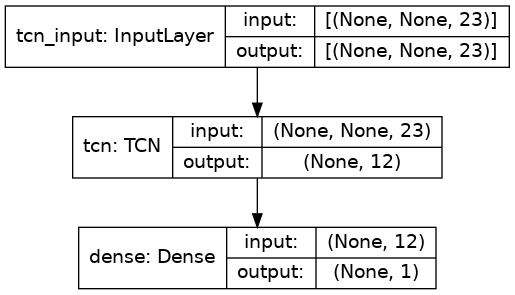

In [7]:
plot_model(model=model, show_dtype=False, show_layer_names=True, show_shapes=True, to_file='TCN_audio.png')

### Model training

Model training setup is based on an iterative approach where model is trained one file at a time, then learned parameters are saved and loaded in the next iterative step. This setup is necessary due to the fact that source files does not have an uniform size and differ in number of frames.

In [8]:
# Fit the model one file at a time.
train_index = 0
val_index = 0
loss = {}
train_eval = []
train_loss = []
train_mae = []

for train in x_train:

    train = np.array(train).reshape((1, train.shape[0], -1))
    history = model.fit(x=train, y=y_train[train_index], epochs=10, shuffle=False, batch_size=32, verbose=0, callbacks=early_stop)
    loss.update({train_index:history.history})

    train_index += 1
    
    model.save(r'TCN_audio', include_optimizer=True) # Save model configuration to Saved_models.
    model = load_model(r'TCN_audio', custom_objects={'TCN':TCN}) # Load model configuration from Saved_models.

    scores = model.evaluate([train], y_train[val_index], verbose = 0)
    train_eval.append(scores)
    train_loss.append(scores[0])
    train_mae.append(scores[1])

    val_index += 1


2022-05-28 12:11:31.976434: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-28 12:11:31.976760: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994365000 Hz
2022-05-28 12:11:33.072483: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-28 12:11:33.265434: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-05-28 12:11:34.129786: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-05-28 12:11:34.172587: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-05-28 12:11:42.583164: W tensorflow/python

INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


INFO:tensorflow:Assets written to: TCN_audio/assets


In [9]:
avg_train_loss = sum(train_loss) / len(train_loss)
avg_train_mae = sum(train_mae) / len(train_mae)
print("Train loss visual (avg):", avg_train_loss, "Train MAE visual (avg):", avg_train_mae)

Train loss visual (avg): 0.3344604989636038 Train MAE visual (avg): 0.38605620600999546


### Model evaluation

Model evaluation is performed on subset taken from test data. 

In [10]:
x_val = x_test[:30].copy()
y_val = y_test[:30].copy()

In [11]:
eval_loss = []
eval_mae = []
eval_visual = []
index = 0

for input in x_val:
    input = reshape_X(input)
    scores = model.evaluate(input, y_val[index], verbose = 0)
    
    eval_visual.append(scores)
    eval_loss.append(scores[0])
    eval_mae.append(scores[1])
    
    index += 1

In [12]:
avg_eval_loss = sum(eval_loss) / len(eval_loss)
avg_eval_mae = sum(eval_mae) / len(eval_mae)
print("Validation loss visual (avg):", avg_eval_loss, "Validation MAE visual (avg):", avg_eval_mae)

Validation loss visual (avg): 2.965661349194124 Validation MAE visual (avg): 1.1275857850909232


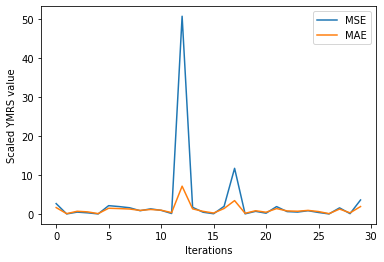

In [13]:
plt.xlabel("Iterations")
plt.ylabel("Scaled YMRS value")
plt.plot(eval_loss, label="MSE")
plt.plot(eval_mae, label="MAE")
plt.legend()
plt.show()

### YMRS prediction and comparison

Prediction is made on different subset taken from the test dataset. Then actual and predicted YMRS values are compared.

In [14]:
x_test  = x_test[30:].copy()
y_actual = y_test[30:].copy()

In [15]:
prediction = []
pred_eval = []
pred_loss = []
pred_mae = []
test_index = 0

for file in x_test:
    file = np.array(file).reshape(1, file.shape[0], -1)

    pred = model.predict(file)

    prediction.append(pred)
    scores = model.evaluate(file, y_actual[test_index], verbose=0)
    pred_eval.append(scores)
    pred_loss.append(scores[0])
    pred_mae.append(scores[1])


    test_index += 1

In [16]:
avg_pred_loss = sum(pred_loss) / len(pred_loss)
avg_pred_mae = sum(pred_mae) / len(pred_mae)
print("Prediction loss visual (avg):", avg_pred_loss, "Prediction MAE visual (avg):", avg_pred_mae)

Prediction loss visual (avg): 2.2902688490847747 Prediction MAE visual (avg): 1.2708334863185882


In [17]:
prediction = np.array(prediction).reshape(-1, 1)
y_actual = y_actual.reshape(-1, 1)

prediction = unscale_Y(prediction,scaler)
y_actual = unscale_Y(y_actual,scaler)

In [18]:
pred_df = pd.DataFrame(data=np.column_stack((y_actual, prediction)), columns=['y_actual','y_pred'])
pred_df['pred_error'] = pred_df['y_actual'] - pred_df['y_pred']
pred_df = pred_df.sort_values(by=['y_actual']).reset_index()
pred_df['y_actual'] = pred_df['y_actual'].apply(np.int64)
pred_df

,index,y_actual,y_pred,pred_error
0,0,0,15.911792,-15.911792
1,1,0,20.116270,-20.116270
2,27,0,26.662979,-26.662979
3,22,0,14.545644,-14.545644
4,16,0,9.450673,-9.450673
5,6,0,16.505882,-16.505882
6,10,1,10.730639,-9.730639
7,29,2,25.798616,-23.798616
8,11,3,22.007269,-19.007269
9,17,3,5.956899,-2.956899


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse = mean_squared_error(pred_df.y_actual, pred_df.y_pred)
mae = mean_absolute_error(pred_df.y_actual, pred_df.y_pred)

mse, mae

(284.0003408907795, 14.151577234268188)

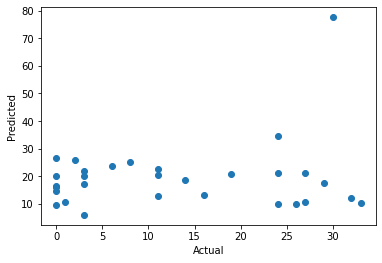

In [20]:
# Scatter plot x = actual, y = predicted
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(pred_df.y_actual, pred_df.y_pred)
plt.show()

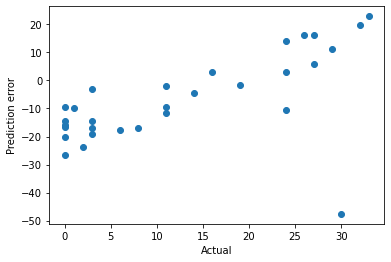

In [21]:
# Scatter plot x = actual, y = actual - predicted
plt.xlabel('Actual')
plt.ylabel('Prediction error')
plt.scatter(pred_df.y_actual, pred_df.pred_error)
plt.show()

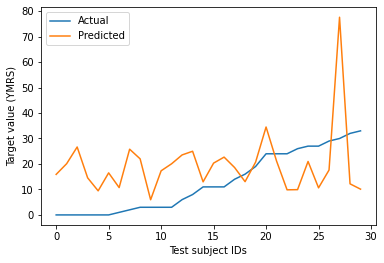

In [22]:
plt.xlabel("Test subject IDs")
plt.ylabel("Target value (YMRS)")
plt.plot(pred_df.y_actual, label="Actual")
plt.plot(pred_df.y_pred, label="Predicted")
plt.legend()
plt.show()